In [8]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 4, 1)
date_to = dt.date(2023, 5, 13)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)
players = u.to_players(battles)

### ブキ統計量を求める

- 1分あたりのキル
- 1分あたりのアシスト
- 1分あたりのデス
- 1分あたりのスペシャル
- 1分あたりの塗り面積


In [9]:
result_cols = ["kill", "assist", "death", "special", "inked"]
weapon_stat = players.groupby(["mode", "weapon"])[result_cols + ["time"]].sum()

for col in result_cols:
    weapon_stat[col] = weapon_stat[col] / weapon_stat["time"] * 60

weapon_stat = weapon_stat.drop(columns="time")
weapon_stat

kill    assist     death   special       inked
mode   weapon                                                              
area   52gal             1.664972  0.392051  1.614945  0.945915  246.352029
       96gal             1.352556  0.370015  1.317555  0.970040  265.496062
       96gal_deco        1.493290  0.273381  1.308607  0.806194  233.653724
       bamboo14mk1       1.183707  0.558053  1.158184  1.046435  255.717915
       barrelspinner     1.101574  0.563562  1.076798  1.061004  280.280297
...                           ...       ...       ...       ...         ...
yagura sshooter_collabo  1.623757  0.418188  1.518440  0.956344  262.809956
       tristringer       0.971176  0.865659  1.054550  1.025357  212.751046
       variableroller    1.467247  0.389699  1.443250  0.962824  276.032774
       wakaba            1.204952  0.470935  1.459571  0.900431  277.455515
       wideroller        1.196273  0.485923  1.750326  0.701333  213.369402

[316 rows x 5 columns]

### 相関係数を確認する

In [10]:
weapon_stat.groupby("mode").corr()

kill    assist     death   special     inked
mode                                                            
area   kill     1.000000 -0.327512  0.713702 -0.607438 -0.536951
       assist  -0.327512  1.000000 -0.077864  0.246982  0.208255
       death    0.713702 -0.077864  1.000000 -0.425870 -0.278396
       special -0.607438  0.246982 -0.425870  1.000000  0.897021
       inked   -0.536951  0.208255 -0.278396  0.897021  1.000000
asari  kill     1.000000 -0.326575  0.650447 -0.550053 -0.380812
       assist  -0.326575  1.000000 -0.096332  0.321025  0.251439
       death    0.650447 -0.096332  1.000000 -0.385920 -0.173658
       special -0.550053  0.321025 -0.385920  1.000000  0.849177
       inked   -0.380812  0.251439 -0.173658  0.849177  1.000000
hoko   kill     1.000000 -0.338746  0.682788 -0.465079 -0.380597
       assist  -0.338746  1.000000 -0.132500  0.300638  0.208055
       death    0.682788 -0.132500  1.000000 -0.289978 -0.135419
       special -0.465079  0.300638 -0.289978  1.000000  0.874498
       inked   -0.380597  0.208055 -0.135419  0.874498  1.000000
yagura kill     1.000000 -0.345175  0.684422 -0.420949 -0.326951
       assist  -0.345175  1.000000 -0.142019  0.242429  0.175418
       death    0.684422 -0.142019  1.000000 -0.390157 -0.234974
       special -0.420949  0.242429 -0.390157  1.000000  0.871699
       inked   -0.326951  0.175418 -0.234974  0.871699  1.000000

### 主成分分析を行う

In [11]:
from sklearn.decomposition import PCA

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

# ルールごとに主成分、累積寄与率、主成分負荷量を求める
def mode_pca(mode: str, weapon_stat: pd.DataFrame):
    df_mode = weapon_stat.loc[mode].reset_index()
    df_z = df_mode.iloc[:,1:].apply(standardize)
    dimension = len(df_z.columns)
    pc_cols = [f"pc{x+1}" for x in range(dimension)]

    pca = PCA()
    pca.fit(df_z)

    # 各ブキの主成分を求める
    score = pd.DataFrame(pca.transform(df_z), columns=pc_cols)
    score = pd.concat([df_mode.iloc[:,:1], score], axis=1)
    score["mode"] = mode

    # 累積寄与率 cc_ratio を求める
    ev_ratio = pd.DataFrame(pca.explained_variance_ratio_, index=pc_cols)
    cc_ratio = ev_ratio.cumsum().T
    cc_ratio["mode"] = mode

    # 主成分負荷量 eigen_vector を求める
    eigen_vector = pd.DataFrame(pca.components_, columns=df_z.columns, index=pc_cols).reset_index().rename(columns={ "index": "pc" })
    eigen_vector["mode"] = mode

    return score, cc_ratio, eigen_vector

results = [mode_pca(x, weapon_stat) for x in d.MODE_ORDER]
score = pd.concat([x[0] for x in results]).set_index(["mode", "weapon"])
cc_ratio = pd.concat([x[1] for x in results]).set_index("mode")
eigen_vector = pd.concat([x[2] for x in results]).set_index(["mode", "pc"])

cc_ratio

,pc1,pc2,pc3,pc4,pc5
mode,,,,,
area,0.570603,0.761397,0.939291,0.982897,1.0
yagura,0.520772,0.743098,0.920482,0.978067,1.0
hoko,0.518819,0.752184,0.924919,0.979071,1.0
asari,0.534995,0.747000,0.917460,0.976277,1.0


### 可視化する

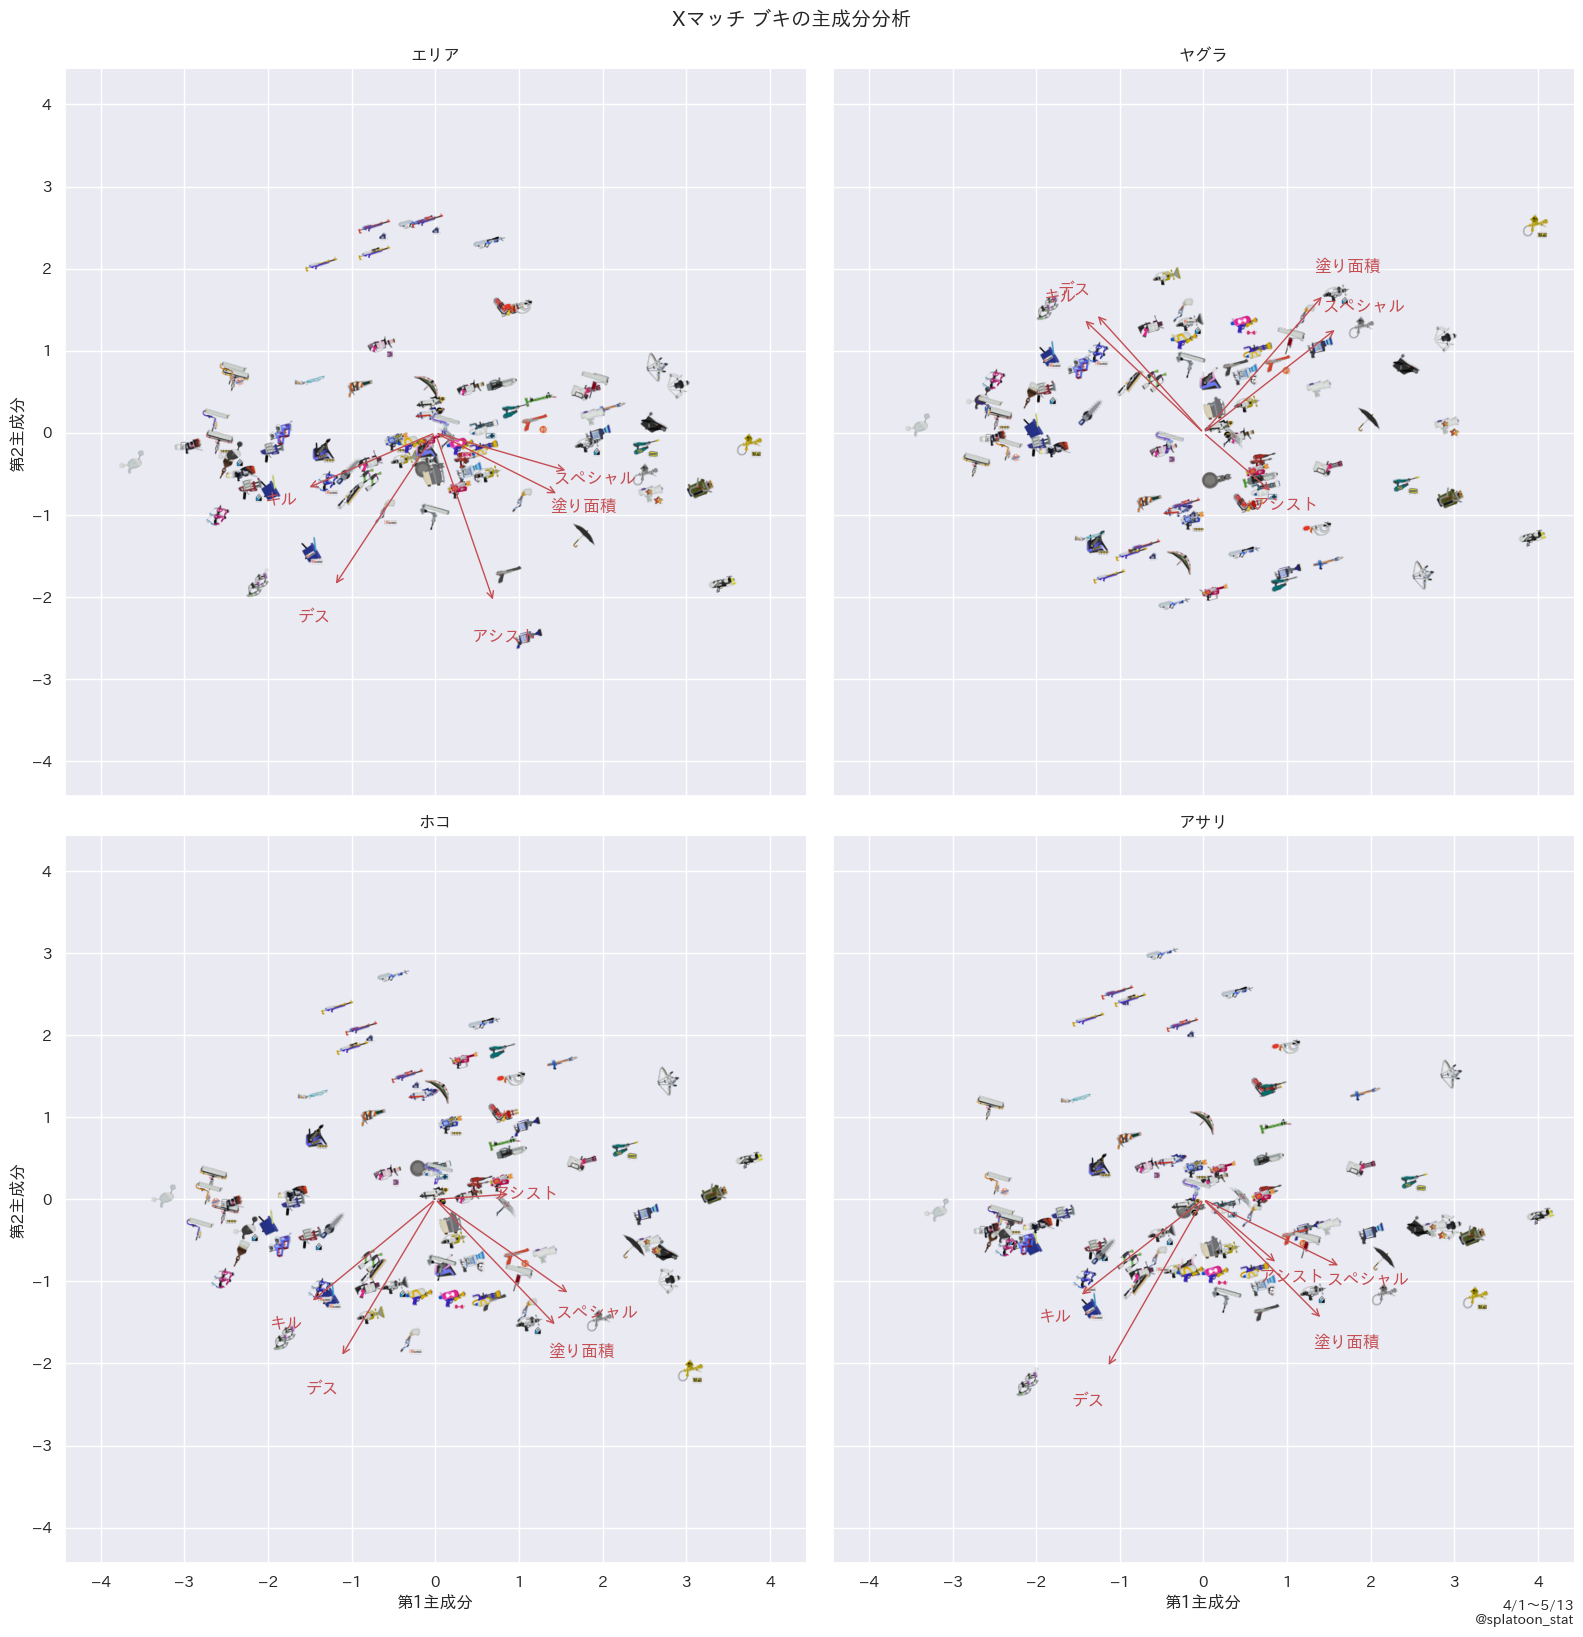

In [12]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキの主成分分析", "Weapon PCA in ${lobby}")
i18n.add("pc1", "第1主成分", "1st component")
i18n.add("pc2", "第2主成分", "2nd component")
i18n.add("kill", "キル", "Kill")
i18n.add("assist", "アシスト", "Assist")
i18n.add("death", "デス", "Death")
i18n.add("special", "スペシャル", "Special")
i18n.add("inked", "塗り面積", "Inked")

value_range = max(score[["pc1", "pc2"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=score,
    x="pc1",
    y="pc2",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=8,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)

g.set(
    xlabel=i18n.t("pc1"),
    ylabel=i18n.t("pc2"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for j, row in score.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["pc1"]
        yvalue = row["pc2"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    for col, item in eigen_vector.loc[mode].items():
        mag = 3
        vec = [item["pc1"], item["pc2"]]
        ax.annotate("", (0, 0), xytext=[x * mag for x in vec], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
        ax.annotate(i18n.t(col), (0, 0), xytext=[x * mag * 1.2 for x in vec], color="r", ha="center", va="center")
    
    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()


In [13]:
score

pc1       pc2       pc3       pc4       pc5
mode  weapon                                                            
area  52gal            -0.787116 -0.349784 -0.935238 -0.288629 -0.317251
      96gal             0.421803  0.546952 -0.570944 -0.136014 -0.014645
      96gal_deco       -0.642042  1.076915 -0.391775 -0.224649  0.106461
      bamboo14mk1       1.252490  0.415992  0.360583 -0.325969 -0.288770
      barrelspinner     1.808561  0.513239  0.283725 -0.303631  0.044238
...                          ...       ...       ...       ...       ...
asari sshooter_collabo  0.137392 -0.888858 -1.006372 -0.477442 -0.012053
      tristringer       2.961431  1.524732  0.970294 -0.466177 -0.630803
      variableroller    1.234394 -0.536927 -1.401316 -0.520737  0.093125
      wakaba            1.509599 -0.309037 -0.938171  0.084539  0.624373
      wideroller       -0.085793  0.133933  0.171806  1.176467  0.094715

[316 rows x 5 columns]